# Question 3.4 Which agricultural variable is affecting corn **early plant growth**? What is the importance of P relatively to other variables?

In this notebook, we aim at assessing the linear effect of agricultural conditions, including the P dosage, on **early plant growth**.

## Load data

Load data exported from the preprocessing session.

In [1]:
load("output/preprocessed.RData")

## Load packages

We obviously need the **`tidyverse`** package for data manipulation and plotting. **`ggthemes`** provides themes for plots. The **`nlme`** package is used for the linear mixted model. The **`broom`** package is used to create tidied **`nlme`** outputs.

In [2]:
library("tidyverse")
library("broom")
library("ggthemes")
library("nlme")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse




## Preparation to modeling

We select the variables to be included in the model.

In [3]:
var_mm <- c(soil_vars, weather_vars_.30, "doseP", "P.Source")
data_mm <- data_rs[c("ID", "Year", "plantbiomass_g", var_mm)]

Filter out missing data.

In [4]:
data_mm <- data_mm %>%
  drop_na() %>%
  droplevels()

Data left for modelling:

In [5]:
print(paste('Number of lines:', nrow(data_mm)))
print(paste('Number of trials:', nlevels(data_mm$ID)))

[1] "Number of lines: 404"
[1] "Number of trials: 142"


## Linear model

There is no *manure* case in the data set for plant growth, discarting the need for separate models.

In [6]:
data_mm %>%
  select(is_manure) %>%
  table()

.
FALSE 
  404 

We begin by scaling all variables by removing the mean and dividing by the standard deviation. This assures that the effects (slopes) of the model can be compared.

In [7]:
scaled_num <- data_mm %>% 
  select(-ID, -Year, -is_manure, -plantbiomass_g, -P.Source) %>%
  scale() %>%
  as_tibble()
data_mm_sc <- bind_cols(data_mm %>% select(ID, Year, plantbiomass_g, P.Source), scaled_num)

We launch split the procedure in two parts, **with and without manure**, which are datasets conducted under different methodologies. Then we run a frequential linear mixed model for each on them, then arrange the table for ploting.

In [8]:
mm_lin <- intervals(lme(as.formula(paste("plantbiomass_g ~ ", paste(var_mm[var_mm != "is_manure"], collapse=" + "),
                               "+ doseP:Soil_P.Al")),
            random = ~ 1|Year/ID,
            data = data_mm_sc))$fixed %>%
  data.frame() %>%
  rownames_to_column(var="Variable") %>%
  filter(Variable != "(Intercept)") %>%
  mutate(Category = c("Soil chemistry", "Soil chemistry",
                      "Soil gensis", "Soil gensis",
                      "Soil texture", "Soil texture", "Soil texture",
                      "Weather", "Weather",
                      "Dose",
                      "Dose","Dose","Dose",
                      "Dose"))

Variables are renamed to readable string.

In [9]:
for (i in 1:nrow(translate_col)) {
  mm_lin$Variable <- sub(pattern = translate_col$from_name_mm[i], 
                                 replacement = translate_col$to_name_mm_long_en[i],
                                 x = mm_lin$Variable)
}
mm_lin$Variable[mm_lin$Variable == 'CHU_.30'] <- "CHU 0-30 days" # instead of tweaking the loop

We plot the slopes and their confidence interval.

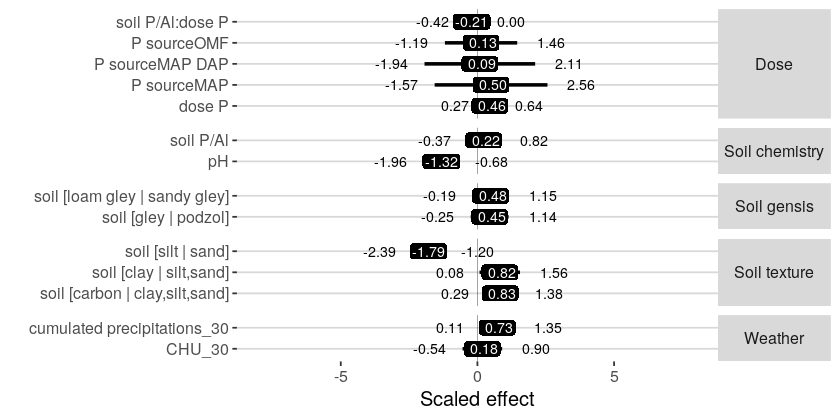

In [10]:
options(repr.plot.width = 7, repr.plot.height = 3.5)
mm_lin %>%
  ggplot() +
  geom_vline(xintercept = 0, lwd = 0.1) +
  geom_segment(aes(x = lower, xend = upper, y = Variable, yend = Variable), lwd = 1) +
  geom_label(aes(x = `est.`, y = Variable, label = format(round(est., 2), nsmall = 2)),
             size = 3, label.padding = unit(0.1, "lines"), colour = "white", fill = "black", label.size = 0) +
  geom_text(aes(x = lower, y = Variable, label = format(round(lower, 2), nsmall = 2)), size = 3, hjust = 1.5) +
  geom_text(aes(x = upper, y = Variable, label = format(round(upper, 2), nsmall = 2)), size = 3, hjust = -0.5) +
  facet_grid(Category ~ ., scales = "free", space = "free") +
  labs(x = "Scaled effect", y = "") +
  expand_limits(x=c(-8, 8)) +
  theme_hc() +
  theme(strip.text.y = element_text(angle = 0))

In [11]:
ggsave("images/earlygrowth_linmod.jpg", height = 3.5, width = 7, dpi = 600)

If we would want absolute effects, we use the dataset `data_mm` instead of `data_mm_sc`.

In [12]:
mm_lin_abs <- intervals(lme(as.formula(paste("plantbiomass_g ~ ", paste(var_mm[var_mm != "is_manure"], collapse=" + "),
                               "+ doseP:Soil_P.Al")),
            random = ~ 1|Year/ID,
            data = data_mm), which = "fixed")$fixed %>%
  data.frame() %>%
  rownames_to_column(var="Variable") %>%
  filter(Variable != "(Intercept)") %>%
  mutate(uncertainty = est.-lower)

Variables are renamed to readable string.

In [13]:
for (i in 1:nrow(translate_col)) {
  mm_lin_abs$Variable <- sub(pattern = translate_col$from_name_mm[i], 
                                 replacement = translate_col$to_name_mm_long_en[i],
                                 x = mm_lin_abs$Variable)
}

In [14]:
mm_lin_abs

Variable,lower,est.,upper,uncertainty
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
pH,-3.414080118,-2.299943531,-1.185806944,1.11413659
soil P/Al,-2.370200005,5.661277177,13.692754360,8.03147718
soil [gley | podzol],-0.155807677,0.284449567,0.724706810,0.44025724
soil [loam gley | sandy gley],-0.094313534,0.235028895,0.564371323,0.32934243
"soil [carbon | clay,silt,sand]",0.770249091,2.239519093,3.708789095,1.46927000
"soil [clay | silt,sand]",0.090725203,0.948507342,1.806289482,0.85778214
soil [silt | sand],-4.471174463,-3.354890031,-2.238605598,1.11628443
cumulated precipitations_30,0.003251189,0.022263647,0.041276105,0.01901246
CHU_30,-0.007002412,0.002335548,0.011673508,0.00933796


**Without manure**, each kg of P per ha had increased early plant growth by 0.057 +/- 0.022 g. A dosage of 40 kg/ha had thus increased early plant growth by 2.3 +/- 0.9 g compared to control.